In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, ToPILImage, Resize
from skimage.io import imread
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler

In [8]:
class BoxDataSet(Dataset):
    
    def __init__(self, fnames, rgbd = True, resize = (224,224)):
        
        self.rgbd = rgbd
        self.resize = resize
        self.y_len = [0]
        self.img_dir = []
        for i in range(len(fnames)):
            self.img_dir.append("./image_data/data" + str(fnames[i]))
            self.data = np.load("./position_data/data" + str(fnames[i]) + ".npz")
            if i == 0:
                self.y_train = torch.tensor(self.data["position"]).float()
                self.y_len.append(len(self.data["position"])-1)
                
            else:
                self.y_train = torch.vstack((self.y_train, torch.tensor(self.data["position"]).float()))
                self.y_len.append(self.y_len[-1] + len(self.data["position"]))
                        
    def __len__(self):
        return len(self.y_train)
    
    def __getitem__(self, gidx):
        
        
        b_idx = max(np.searchsorted(self.y_len, gidx)-1,0) # which dir to look into
        idx = max(gidx - self.y_len[b_idx] - 1,0) # relative idx
        
        image = ToTensor()(imread(self.img_dir[b_idx] + "/color_" + str(idx) + ".jpg"))
        if self.rgbd:
            d_image = ToTensor()(imread(self.img_dir[b_idx] + "/depth_" + str(idx) + ".jpg"))
            image = torch.vstack((image, d_image))
        else:
            image = transforms.Resize(self.resize)(image)
        
        label = self.y_train[gidx]
        
        return image.float(), label
                
    
    def get_data(self, gidx):
        
        
        b_idx = max(np.searchsorted(self.y_len, gidx)-1,0) # which dir to look into
        idx = max(gidx - self.y_len[b_idx] - 1,0) # relative idx
        
        image = ToTensor()(imread(self.img_dir[b_idx] + "/color_" + str(idx) + ".jpg"))
        if self.rgbd:
            d_image = ToTensor()(imread(self.img_dir[b_idx] + "/depth_" + str(idx) + ".jpg"))
            image = torch.vstack((image, d_image))
        else:
            image = transforms.Resize(self.resize)(image)
            
        label = self.y_train[gidx]
        
        return image.float()[None,:,:,:], label



In [51]:
# loading pretrainined net
class PreTrained(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = True
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.out = nn.Linear(256, 3)
    
    def forward(self, x):
        
        x = self.resnet(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        
        return x

In [52]:
device = torch.device("cuda")
net = PreTrained()
# net.load_state_dict(torch.load("./models/pre1"))
net = net.to(device)
lr = 1.0e-3
eps = 1000
indices = [1,2,3,4,5,6,7]
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = torch.nn.MSELoss() #torch.nn.MSELoss() #torch.nn.HuberLoss()
data = DataLoader(BoxDataSet(indices, rgbd = False, resize = (224,224)), \
                  batch_size = 64, num_workers = 12, shuffle=True)

In [ ]:
for i in range(eps):
    for x_train_batch, y_train_batch in data:
        x_train_gpu = x_train_batch.to(device)
        y_train_gpu = y_train_batch.to(device)
        y_pred = net(x_train_gpu)
        error = loss(y_pred, y_train_gpu) 
        print("The iteration number : " + str(i) + " The loss is :" + str(error.cpu().detach().numpy()), end='\r', flush  = True)
        optimizer.zero_grad()
        error.backward()
        optimizer.step()
        
    if i % 10 == 0:
        torch.save(net.state_dict(), "./models/pre1")
        
torch.save(net.state_dict(), "./models/pre1")    

In [27]:
dl = BoxDataSet(indices, rgbd = False, resize = (224,224))
net = PreTrained()
net.load_state_dict(torch.load("./models/pre1"))

<All keys matched successfully>

tensor([0.0374, 0.6981, 0.4986]) tensor([[0.2841, 0.3346, 0.4788]]) tensor(0.4397)


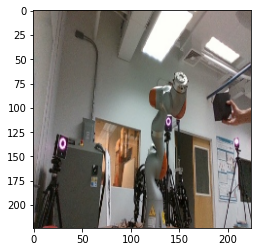

In [50]:
with torch.no_grad():
    image, label = dl.get_data(np.random.randint(10000))
    pred = net(image)
    print(label, pred, torch.linalg.norm(label-pred))
    box = ToPILImage()(image[0][:3])
    plt.imshow(box)